<a href="https://colab.research.google.com/github/EricRibeiroAlves/Interacao-Humano-Robo/blob/main/Codigo/%5BAP_T%5D_Eric_Markovs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Legenda**:
- $dt$: Passo de tempo (incremento de tempo entre as amostras).
- $t$: Tempo total (ou carimbo de tempo) da amostra.
- $\frac{d\tau_{r}}{dt}$ [R_d_T]: Derivada do torque do robô (variação do torque com o tempo).
- $\tau_{r}$ [R_T]: Torque do robô.
- $S_Fx$ [R_Fx]: Sensor de torque Tx.
- $\omega_{l}$ [R_w_l]: Velocidade da coroa.
- $\theta_{l}$ [R_t_l]: Ângulo da coroa.
- $\omega_{h}$ [R_w_p]: Velocidade da pessoa.
- $\theta_{h}$ [R_t_p]: Ângulo da pessoa.
- $∫e(Interacao).dt$ [R_i_T_e]: Integral do erro de torque.
- $U(x)$ [R_u]: Sinal de controle.
- $\tau^{d}_{r}$ [R_T_d]: Torque desejado do robô.
- $\theta_{m}$ [R_t_m]: Ângulo do motor.
- $\frac{d\omega_{l}}{dt}$ [R_d_w_l]: Derivada da velocidade da coroa (variação da velocidade da coroa com o tempo).
- $phase$: Fase do movimento ou do ciclo (possivelmente relacionada à fase da marcha).
- $\theta_{m, L}$ [L_t_m]: Ângulo do motor na perna esquerda.
- $\theta_{l, L}$ [L_t_l]: Ângulo da coroa na perna esquerda.
- $L_u$: Sinal de controle aplicado ao lado esquerdo.
- $\tau_{r, L}$ [L_T_r]: Torque real no lado esquerdo.
- $\tau^{d}_{r, L}$ [L_T_d]: Torque desejado no lado esquerdo.

### Variáveis adicionais (não presentes no dataset mas relevantes no código):
- $\tau_{i}$ [R_T_i]: Torque de interação.

# Bibliotecas

In [12]:
# Trato dos dados
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
from google.colab import sheets

# Libs p/ Modelo Deep LTSM
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.losses import Huber
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# 1º Passo: Montar o Drive e carregar o dataset


In [19]:
head_markov = ['dt', 't', 'R_d_T', 'R_T', 'R_Fx',
               'R_w_l', 'R_t_l', 'R_w_p', 'R_t_p',
               'R_i_T_e', 'R_u', 'R_T_d', 'R_t_m',
               'R_d_w_l', 'phase', 'L_t_m', 'L_t_l',
               'L_u', 'L_T_r', 'L_T_d']

drive.mount('/content/drive')

t1_markov = "drive/MyDrive/Markov/T1_1/last_data_MarkovMao 1.dat"
t2_markov = "drive/MyDrive/Markov/T2/last_data_MarkovMao 1.dat"
t3_markov = "drive/MyDrive/Markov/T3/last_data_MarkovMao 1.dat"
t4_markov = "drive/MyDrive/Markov/T4/last_data_MarkovMao 1.dat"
t5_markov = "drive/MyDrive/Markov/T5_1/last_data_MarkovMao 1.dat"
t6_markov = "drive/MyDrive/Markov/T6/last_data_MarkovMao 1.dat"
t7_markov = "drive/MyDrive/Markov/T7/last_data_MarkovMao 1.dat"
t8_markov = "drive/MyDrive/Markov/T8/last_data_MarkovMao 1.dat"

pd.set_option('display.float_format', lambda x: '%.10f' % x)

# Precido de: ['R_w_l'] F, ['R_t_l'] G, ['R_w_p'] H, ['R_t_p'] I

markov_t1 = pd.read_table(t1_markov, header=None, names=head_markov, index_col=False) # Sem: R_T_d, R_w_l com falhas
markov_t2 = pd.read_table(t2_markov, header=None, names=head_markov, index_col=False) # Sem: ; *R_w_l com falhas (esse ta ótimo!) ♥
markov_t3 = pd.read_table(t3_markov, header=None, names=head_markov, index_col=False) # Sem: R_w_l, R_T_d
markov_t4 = pd.read_table(t4_markov, header=None, names=head_markov, index_col=False) # Sem: R_w_l, R_T_d
markov_t5 = pd.read_table(t5_markov, header=None, names=head_markov, index_col=False) # Sem: R_T_d; R_w_l com falhas
markov_t6 = pd.read_table(t6_markov, header=None, names=head_markov, index_col=False) # Sem: ; *R_w_l com falhas (esse ta ótimo!) ♥
markov_t7 = pd.read_table(t7_markov, header=None, names=head_markov, index_col=False) # Sem: R_w_l, R_T_d, L_T_d                    *Sendo Utilizado nos Modelos (!!)
markov_t8 = pd.read_table(t8_markov, header=None, names=head_markov, index_col=False) # Sem: R_w_l, R_T_d


Mounted at /content/drive


In [3]:
drive.flush_and_unmount()

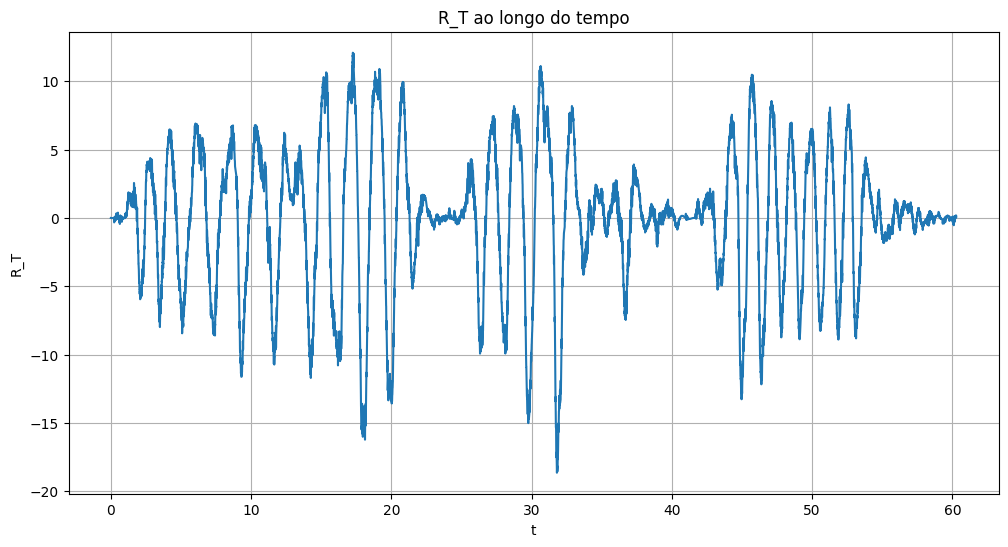

In [9]:
# Gráfico de linha para uma coluna
plt.figure(figsize=(12, 6))
plt.grid(True)
plt.plot(markov_t1['t'].iloc[:], markov_t1['R_T'].iloc[:])
plt.title('R_T ao longo do tempo')
plt.xlabel('t')
plt.ylabel('R_T')
plt.show()

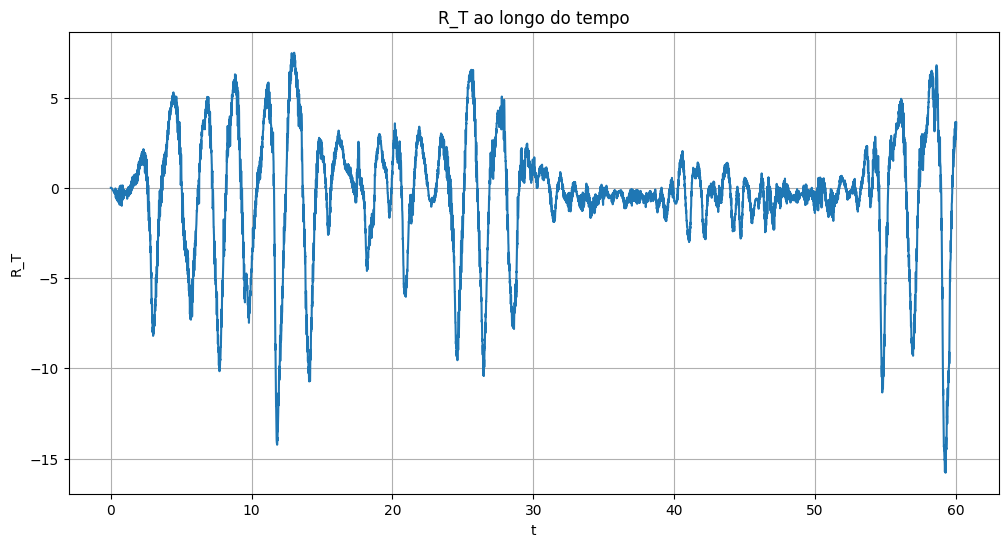

In [5]:
# Gráfico de linha para uma coluna
plt.figure(figsize=(12, 6))
plt.grid(True)
plt.plot(markov_t2['t'].iloc[:], markov_t2['R_T'].iloc[:])
plt.title('R_T ao longo do tempo')
plt.xlabel('t')
plt.ylabel('R_T')
plt.show()

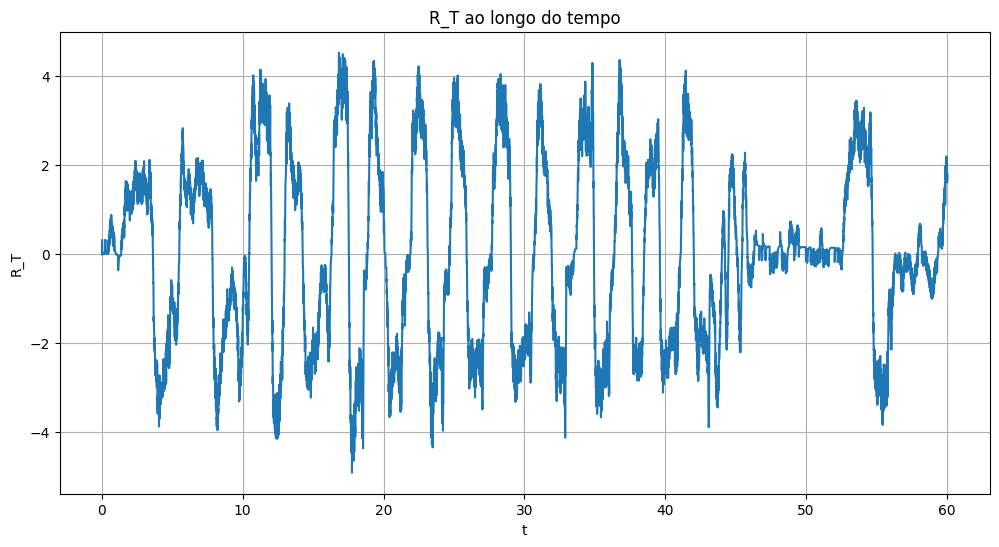

In [6]:
# Gráfico de linha para uma coluna
plt.figure(figsize=(12, 6))
plt.grid(True)
plt.plot(markov_t3['t'].iloc[:], markov_t3['R_T'].iloc[:])
plt.title('R_T ao longo do tempo')
plt.xlabel('t')
plt.ylabel('R_T')
plt.show()

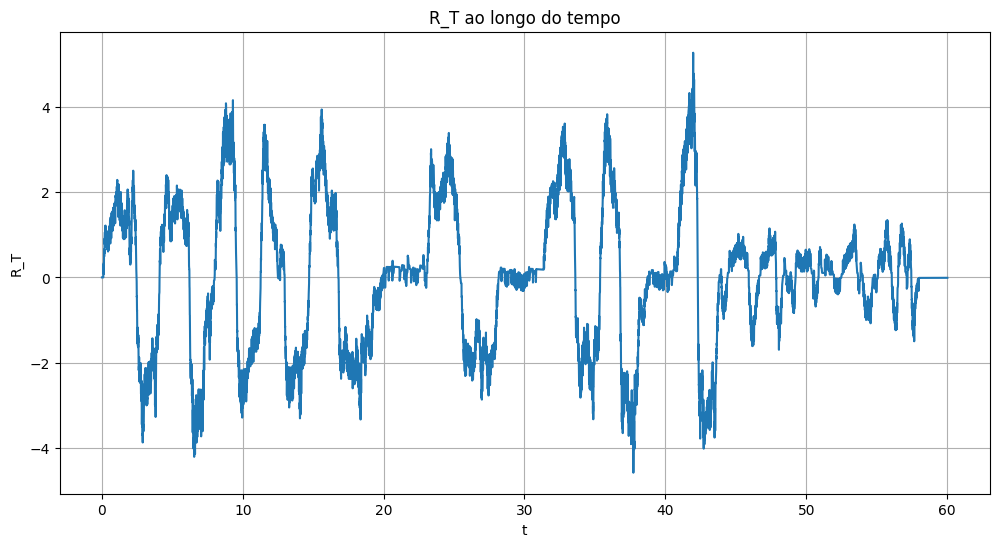

In [7]:
# Gráfico de linha para uma coluna
plt.figure(figsize=(12, 6))
plt.grid(True)
plt.plot(markov_t4['t'].iloc[:], markov_t4['R_T'].iloc[:])
plt.title('R_T ao longo do tempo')
plt.xlabel('t')
plt.ylabel('R_T')
plt.show()

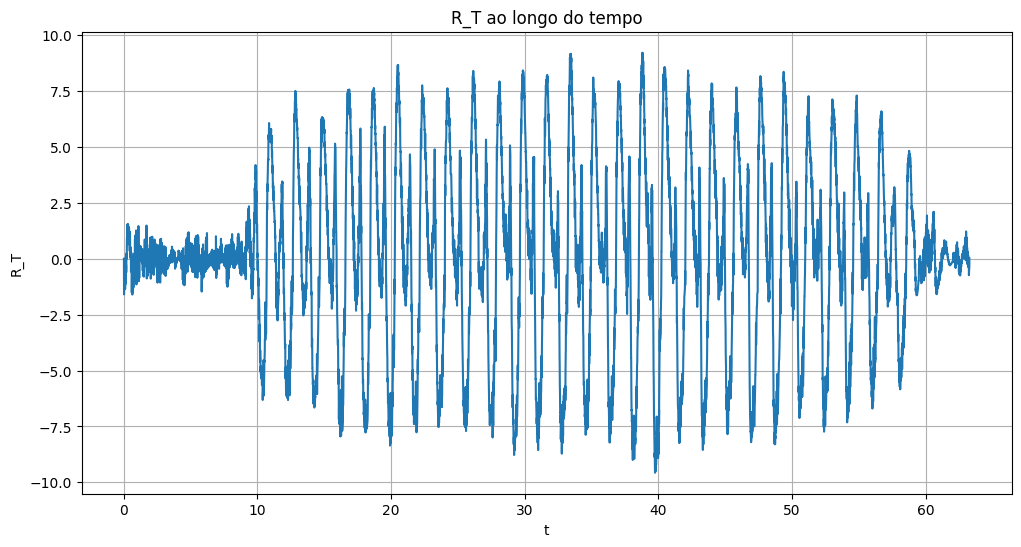

In [8]:
# Gráfico de linha para uma coluna
plt.figure(figsize=(12, 6))
plt.grid(True)
plt.plot(markov_t5['t'].iloc[:], markov_t5['R_T'].iloc[:])
plt.title('R_T ao longo do tempo')
plt.xlabel('t')
plt.ylabel('R_T')
plt.show()

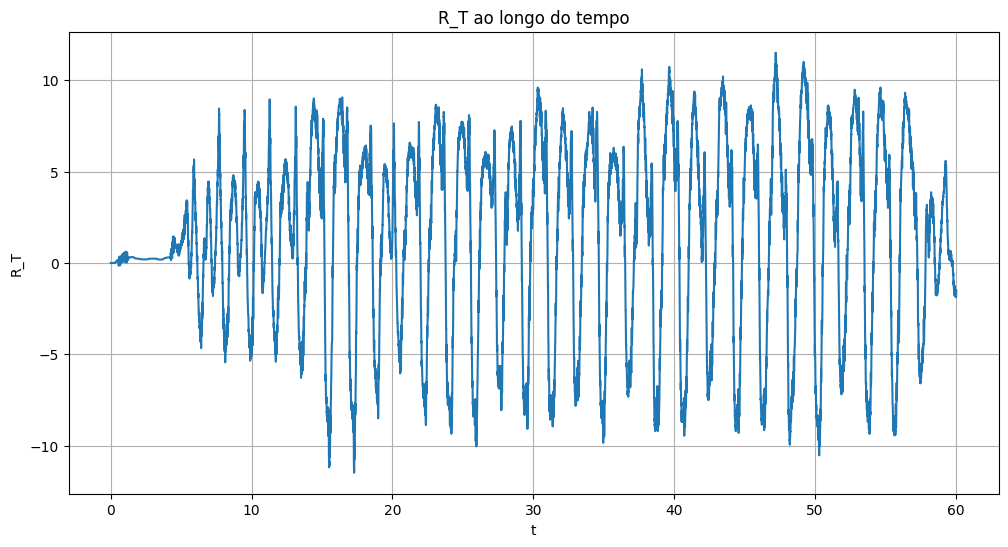

In [ ]:
# Gráfico de linha para uma coluna
plt.figure(figsize=(12, 6))
plt.grid(True)
plt.plot(markov_t6['t'].iloc[:], markov_t6['R_T'].iloc[:])
plt.title('R_T ao longo do tempo')
plt.xlabel('t')
plt.ylabel('R_T')
plt.show()

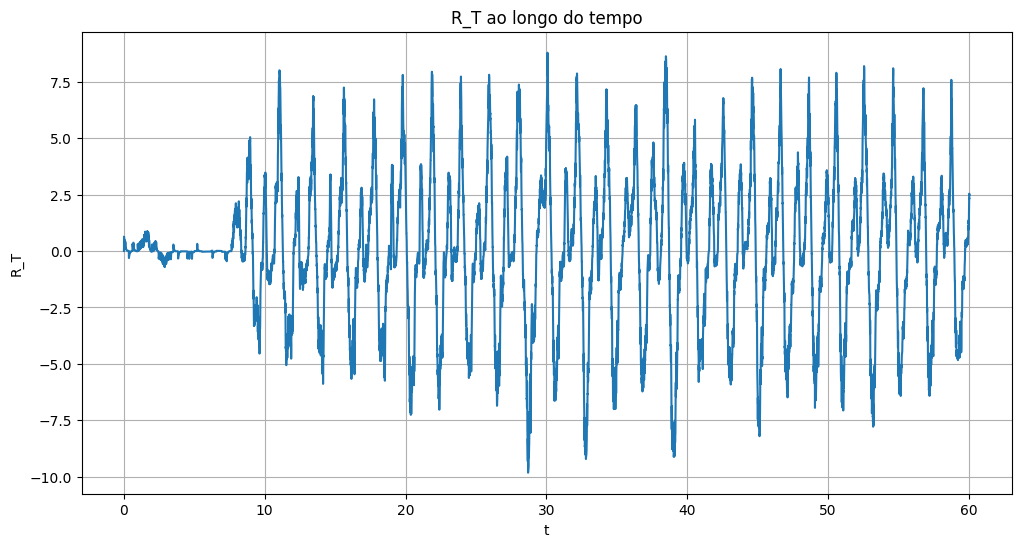

In [ ]:
# Gráfico de linha para uma coluna
plt.figure(figsize=(12, 6))
plt.grid(True)
plt.plot(markov_t7['t'].iloc[:], markov_t7['R_T'].iloc[:])
plt.title('R_T ao longo do tempo')
plt.xlabel('t')
plt.ylabel('R_T')
plt.show()

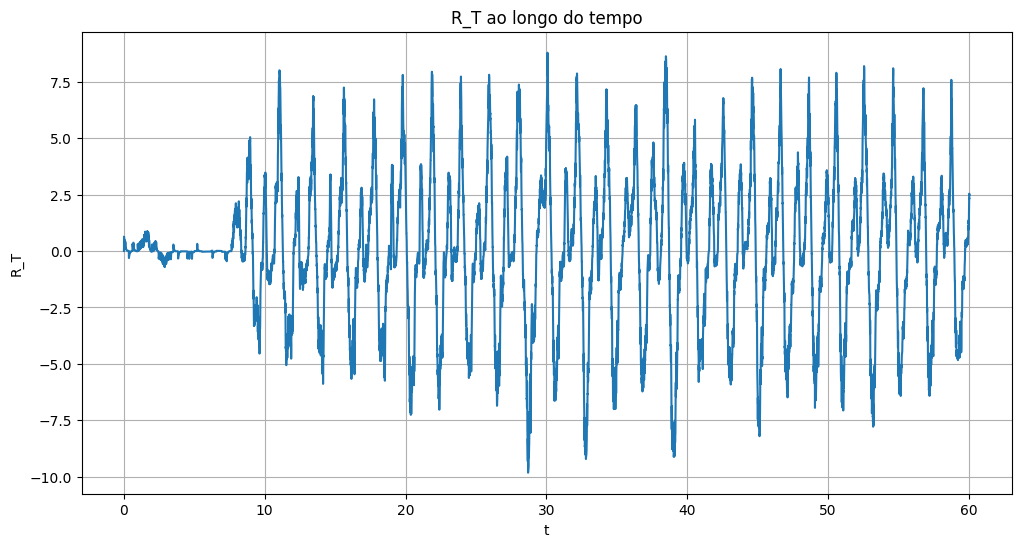

In [ ]:
# Gráfico de linha para uma coluna
plt.figure(figsize=(12, 6))
plt.grid(True)
plt.plot(markov_t7['t'].iloc[:], markov_t7['R_T'].iloc[:])
plt.title('R_T ao longo do tempo')
plt.xlabel('t')
plt.ylabel('R_T')
plt.show()